# C3S Atlas notebooks

***

>This notebook reproduces and extends parts of the figures and products provided by the Copernicus Interactive Climate Atlas (C3S Atlas, [https://atlas.climate.copernicus.eu/atlas](https://atlas.climate.copernicus.eu/atlas)). It is part of a notebook library produced for reproducibility and reusability purposes. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0) and has been produced by IFCA-CSIC and Predictia for the C3S.
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

# Annual Cicle

This Jupyter Notebook reproduces the Annual cycle product from the C3S Atlas.

The annual cycle product (for **observations/reanalysis**) displays the regionally aggregated monthly climatologies for the selected variable and period.

The annual cycle product (for **model** and **paleoclimate** simulations) displays the regionally aggregated monthly climatologies of the selected period for the raw values or the changes (anomalies relative to the selected baseline in this case) for all the simulations forming the ensemble, as well as the ensemble median. The “Mask” filtering allows selecting regional information.

### Load Python packages and clone and install the **user-tools** repository from the C3S Atlas GitLab repository

Clone (`git clone`) the [C3S-Atlas-user-tools](https://gitlab.predictia.es/c3s-cica/c3s-atlas) repository and install them (`pip install -e .`).

Further details on how to clone and install the repository are available in the requirements section of the README: https://gitlab.predictia.es/c3s-cica/c3s-atlas#requirements

In [1]:
import xarray as xr
import glob
import os
from datetime import date
import numpy as np
from pathlib import Path
import cdsapi

from c3s_atlas.software.utils import (
    season_get_name,
    extract_zip_and_delete,
)
from c3s_atlas.software.customized_regions import (
    Mask
)
from c3s_atlas.software.analysis import (
    mean_month, 
)
from c3s_atlas.software.products import (
    annual_cycle,
)
from c3s_atlas.software.GWLs import (
    load_GWLs,
    select_member_GWLs,
    get_mean_data_by_months
)

### Dowload climate data with the CDS API
- Catalog: [Copernicus Interactive Climate Atlas: gridded monthly dataset](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview)

- [How to use the CDS API](https://cds.climate.copernicus.eu/api-how-to](https://cds.climate.copernicus.eu/api-how-to)

In [2]:
project = "CMIP6"
scenario = "ssp370"
var = 'pr'
# directory to download the files
dest = Path('./data/CMIP6')
os.makedirs(dest, exist_ok=True)

##### Download historical data

In [ ]:
filename = 'pr_CMIP6_historical_mon_185001-201412.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    'origin': 'cmip6',
    'experiment': 'historical',
    'domain': 'global',
    'variable': 'monthly_mean_of_daily_accumulated_precipitation',
    'area': [44.5, -9.5, 35.5, 3.5]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

##### Download SSP scenario

In [ ]:
filename = 'pr_CMIP6_ssp370_mon_201501-210012.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    'origin': 'cmip6',
    'experiment': 'ssp3_7_0',
    'domain': 'global',
    'variable': 'monthly_mean_of_daily_accumulated_precipitation',
    'area': [44.5, -9.5, 35.5, 3.5]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

#### Concatenate historical and SSP scenarios
Note that the historical and SSP scenarios might have different number of members

In [17]:
ds_hist = xr.open_dataset(dest / "pr_CMIP6_historical_mon_185001-201412.nc")
ds_sce = xr.open_dataset(dest / "pr_CMIP6_ssp370_mon_201501-210012.nc")
mem_inters = np.intersect1d(ds_hist.member_id.values, ds_sce.member_id.values)
ds_hist = ds_hist.isel(member = np.isin(ds_hist.member_id.values, mem_inters))
ds_sce = ds_sce.isel(member = np.isin(ds_sce.member_id.values, mem_inters))
ds = xr.concat([ds_hist, ds_sce], dim = 'time')

##### Define attributes

In [18]:
actual_year = date.today().year
unit = ds[var].units

attrs = {
    "project" : project,
    "scenario": scenario,
    "variable": var,
    "unit" : unit    
}

#### Select Region

In [19]:
mask = Mask(ds).European_contries(['ESP'])
filtered_ds = ds.where(mask)

## Climatology and change

#### a) Climatology

In [20]:
# calculate annual cycle (climatology)
mode = 'climatology'
period = slice('1/1/2081','31/12/2100')
annual_cycle_ds = monthly_weighted_average(filtered_ds, var, mode = mode)

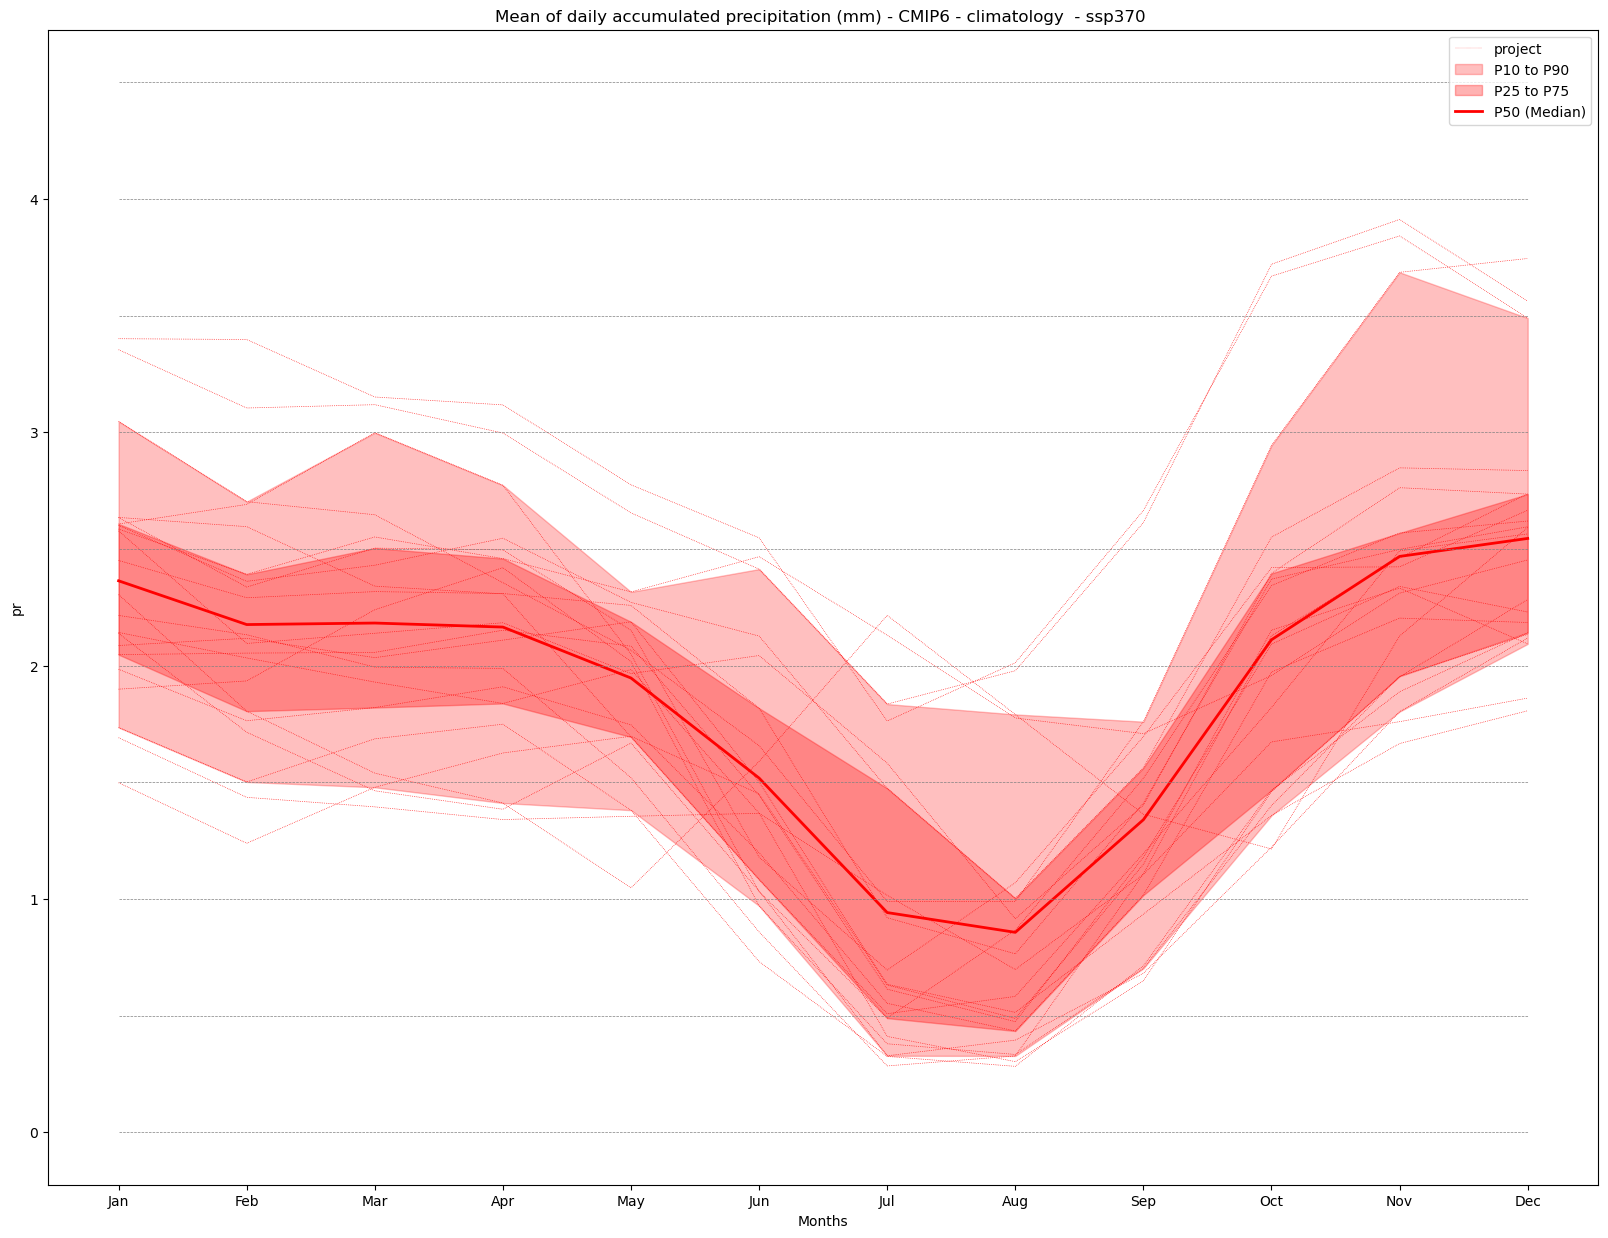

In [21]:
annual_cicle_plot = annual_cycle(annual_cycle_ds, var, attrs, mode = mode, period = period)

#### b) Absolute change

In [22]:
# calculate annual cycle (abs)
mode = 'change'
diff = 'abs'
period = slice('1/1/2081','31/12/2100')
baseline_period = slice('1/1/1981','31/12/2010')

In [23]:
annual_cycle_abs_ds = monthly_weighted_average(filtered_ds, var, mode = mode, diff = diff,
                                               baseline_period = baseline_period, period = period)

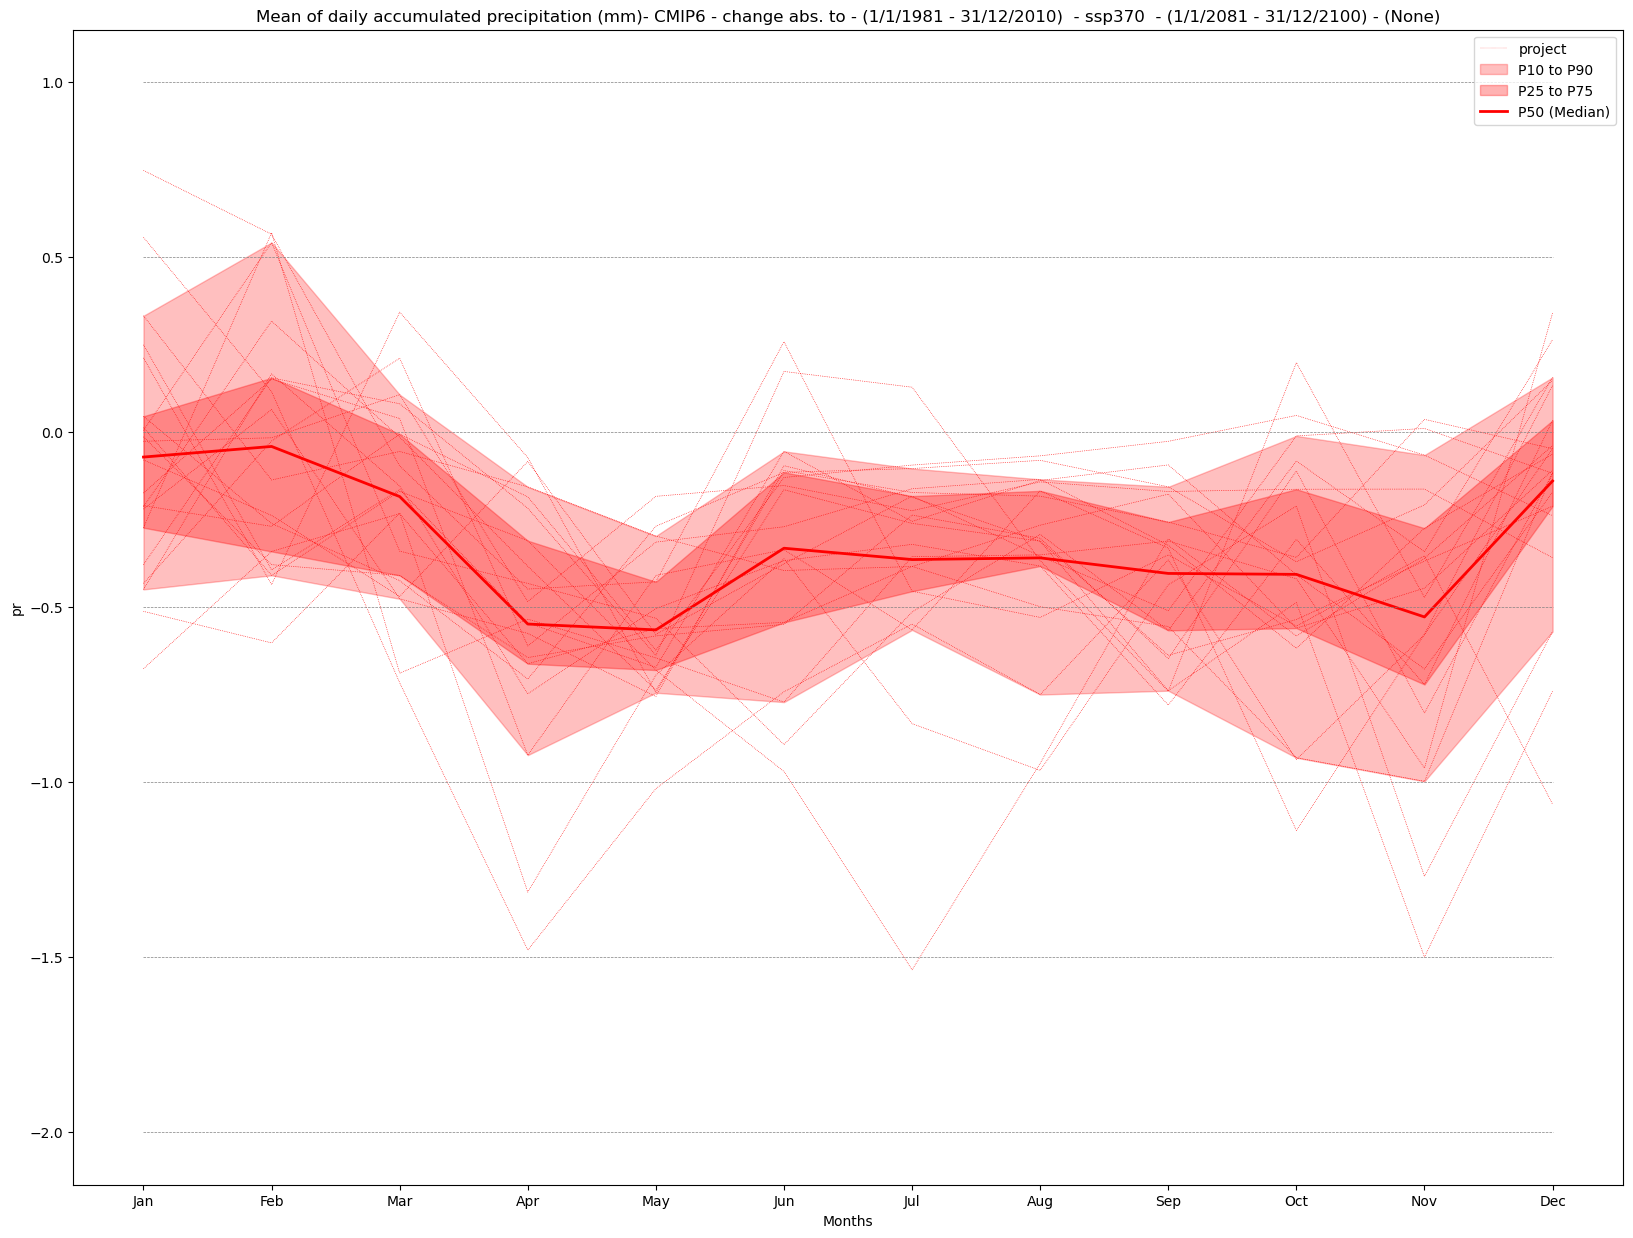

In [24]:
annual_cicle_plot = annual_cycle(annual_cycle_abs_ds, var, attrs, 
                                 mode = mode, diff = diff, 
                                 baseline_period = baseline_period, period = period)

#### c) Relative change

In [25]:
# calculate annual cycle (rel)
mode = 'change'
diff = 'rel'
period = slice('1/1/2081','31/12/2100')
baseline_period = slice('1/1/1981','31/12/2010')

In [26]:
annual_cycle_rel_ds = monthly_weighted_average(filtered_ds, var, mode = mode, diff = diff,
                                               baseline_period = baseline_period, period = period)

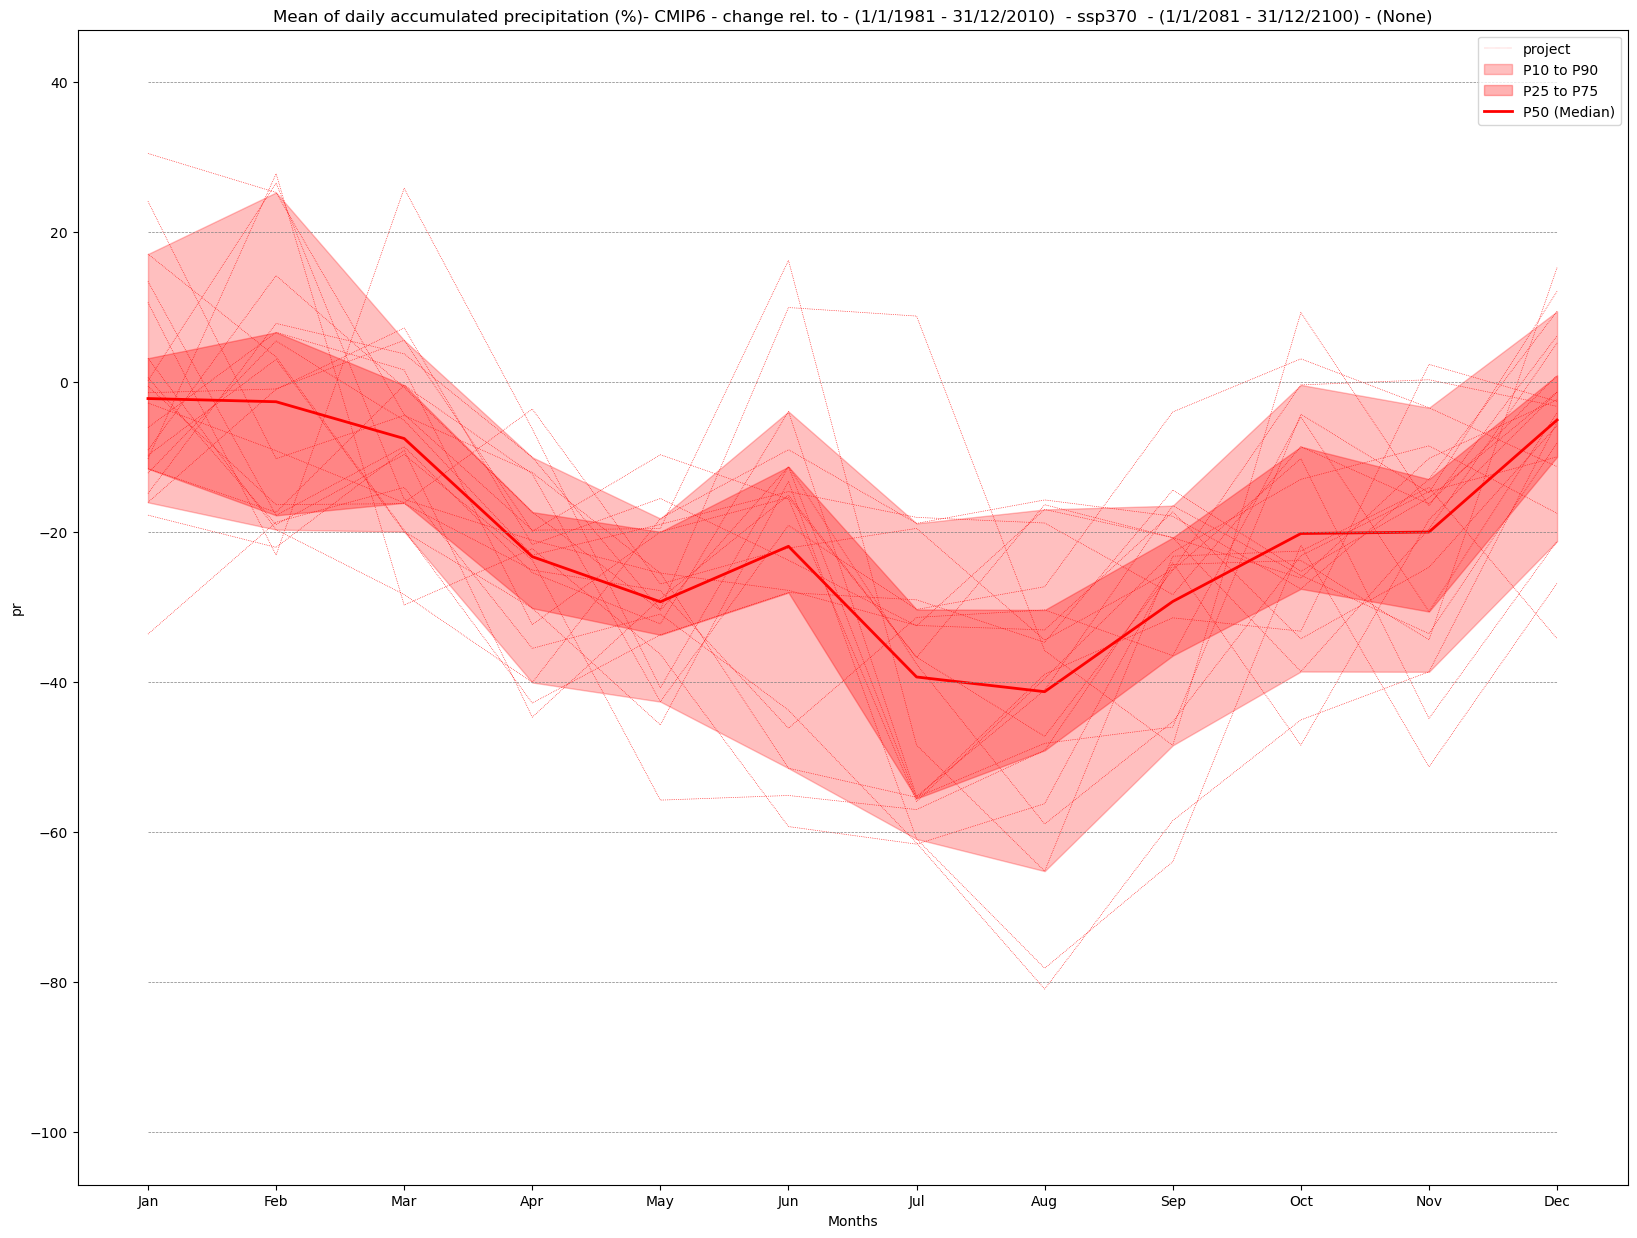

In [27]:
annual_cicle_plot = annual_cycle(annual_cycle_rel_ds, var, attrs, 
                                 mode = mode, diff = diff, 
                                 baseline_period = baseline_period, period = period)

## Global warning Levels

In [28]:
GWL = '4'
baseline_period = slice('1/1/1981','31/12/2010')

In [29]:
#Load the data and get the intersection of the members
GWLs_ds = load_GWLs(project)
GWLs_members_with_period = select_member_GWLs(filtered_ds, GWLs_ds, project, scenario, GWL)
[GWL_data, filtered_GWLs_ds] = get_mean_data_by_months(filtered_ds, GWLs_members_with_period)

#### Analysis and plot

In [30]:
mode = 'change'
diff = 'abs'
annual_cycle_GWLs = monthly_weighted_average(filtered_GWLs_ds, var, mode = mode, diff = diff, 
                                             baseline_period = baseline_period, ds_GWLs = GWL_data)

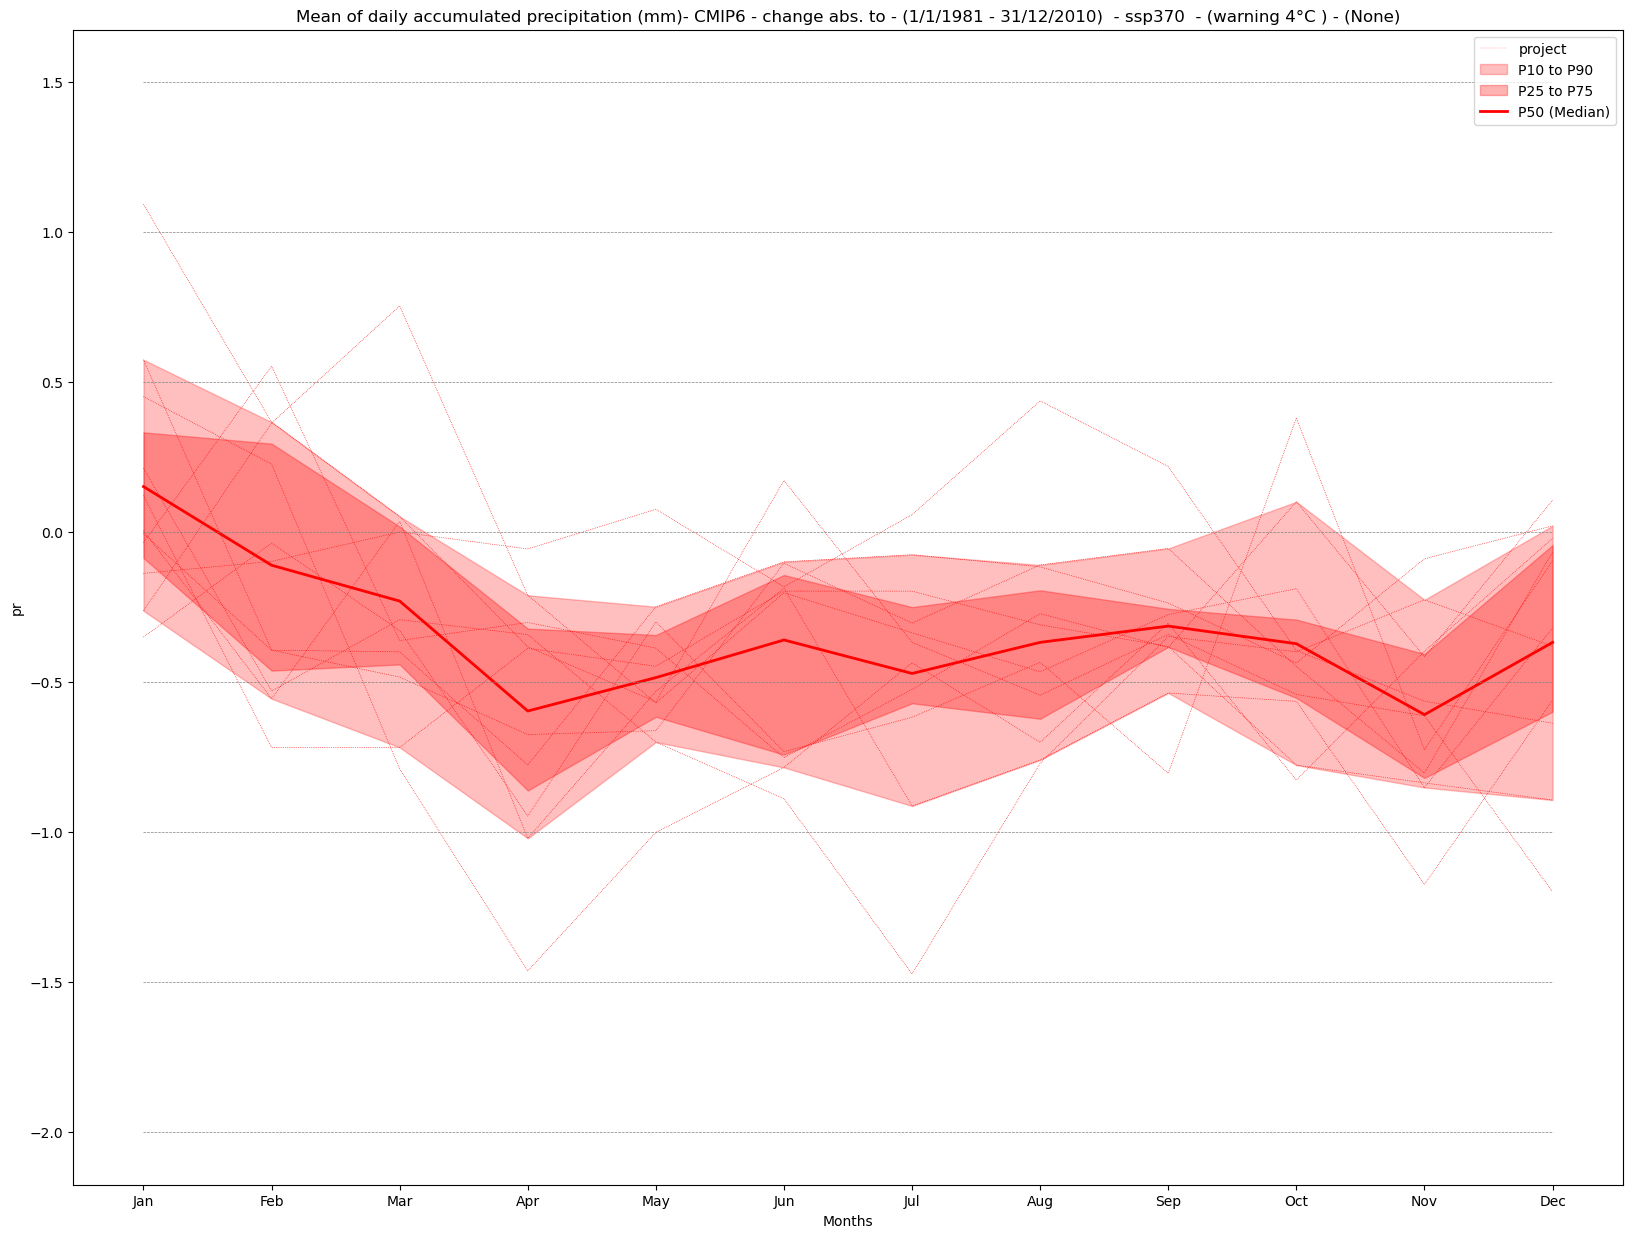

In [31]:
annual_cicle_plot = annual_cycle(annual_cycle_GWLs, var, attrs, mode = mode, diff = diff, 
                                 baseline_period = baseline_period, GWLs = GWL)